In [1]:
import os
import sys
import numpy as np
from PIL import Image
from keras.models import Sequential
from keras.layers import Dropout, Dense, BatchNormalization
from keras.layers import Flatten, Conv2D, MaxPool2D, Activation
from keras.optimizers import RMSprop
from keras.optimizers.schedules import ExponentialDecay
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf

from random import shuffle
from glob import glob
import shutil
from shutil import copyfile

In [2]:
# Code for Correcting Error
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


# Define Print Progress Bar Function
def print_progress(iteration, total, prefix='>> Progress:', suffix='Complete', decimals=1, bar_length=55):
    str_format = "{0:." + str(decimals) + "f}"
    current_progress = iteration / float(total)
    percents = str_format.format(100 * current_progress)
    filled_length = int(round(bar_length * current_progress))
    bar = "■" * filled_length + '□' * (bar_length - filled_length)
    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),
    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

1 Physical GPUs, 1 Logical GPUs


In [3]:
def move_data(train_dir, valid_dir, base_dir):
    
    # 1차적으로 모든 데이터를 train_dir로 옮겨준다
    for subdir, dirs, files in os.walk(base_dir):
        if subdir == base_dir:
            continue
           
        fish_type = subdir[len(base_dir):]
        os.makedirs(train_dir + fish_type)
        for file in files:
            copyfile(os.path.join(subdir, file), os.path.join(train_dir + fish_type, file))
        
        print(f'number of files in {subdir[len(base_dir):]} = {len(os.listdir(subdir))}')
    
    # 이후 validation에 사용할 랜덤 데이터를 옮겨준다
    for subdir, dirs, files in os.walk(train_dir):
        if subdir == train_dir:
            continue
        
        valid_files = np.random.choice(files, int(len(os.listdir(subdir)) * 0.3), replace=False)
        
        print(f'number of validation files = {len(valid_files)}')
        
        fish_type = subdir[len(train_dir):]
        os.makedirs(valid_dir + fish_type)
        for file in valid_files:
            shutil.move(os.path.join(subdir, file), os.path.join(valid_dir+fish_type, file))

In [17]:
base_dir = './dataset'
train_dir = './training_data/train/'
valid_dir = './training_data/validate/'

# if directory is empty, copy files
if not os.listdir(train_dir):
    print('start moving data')
    move_data(train_dir, valid_dir, base_dir)
else:
    print('remove data first\n. . .')
    shutil.rmtree(train_dir)
    shutil.rmtree(valid_dir)
    
    os.makedirs(train_dir)
    os.makedirs(valid_dir)
    print('directory emptied. start moving data')
    move_data(train_dir, valid_dir, base_dir)


remove data first
. . .
directory emptied. start moving data
number of files in \catfish_메기 = 87
number of files in \crucian carp_붕어 = 73
number of files in \flatfish_광어 = 62
number of files in \golden mandarin fish_쏘가리 = 51
number of files in \red snapper_참돔 = 70
number of files in \rockfish_우럭 = 53
number of validation files = 26
number of validation files = 21
number of validation files = 18
number of validation files = 15
number of validation files = 21
number of validation files = 15


In [9]:
types = os.listdir(base_dir)
cnt = len(fishes)

img_height = 112
img_width = 112

In [18]:
# Parsing Images
# # Parsing Training Image
x_train = []
y_train = []

# ## Image Parsing Process
print("\nTraining Image Parsing Started")
for idx, type in enumerate(types):
    print("<" + type + "> Image Parsing Progressing")
    label = [0 for i in range(cnt)]
    label[idx] = 1
    img_dir = train_dir + type + '/'
    for top, folder, file in os.walk(img_dir):
        for filename in file:
            print_progress(file.index(filename) + 1, len(file))
            img = Image.open(img_dir + filename)
            img = img.convert("RGB")
            img = img.resize((img_width, img_height))
            img_data = np.asarray(img)
            x_train.append(img_data/255)
            y_train.append(label)
x_train = np.array(x_train)
y_train = np.array(y_train)
print("Training Image Parsing Finished")


Training Image Parsing Started
<catfish_메기> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<crucian carp_붕어> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<flatfish_광어> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<golden mandarin fish_쏘가리> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<red snapper_참돔> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<rockfish_우럭> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
Training Image Parsing Finished


In [19]:
# # Parsing Validation Image
x_val = []
y_val = []
# ## Image Parsing Process
print("\nValidation Image Parsing Started")
for idx, type in enumerate(types):
    print("<" + type + "> Image Parsing Progressing")
    label = [0 for i in range(cnt)]
    label[idx] = 1
    img_dir = valid_dir + type + '/'
    for top, folder, file in os.walk(img_dir):
        for filename in file:
            print_progress(file.index(filename) + 1, len(file))
            img = Image.open(img_dir + filename)
            img = img.convert("RGB")
            img = img.resize((img_width, img_height))
            img_data = np.asarray(img)
            x_val.append(img_data/255)
            y_val.append(label)
x_val = np.array(x_val)
y_val = np.array(y_val)
print("Validation Image Parsing Finished\n")


Validation Image Parsing Started
<catfish_메기> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<crucian carp_붕어> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<flatfish_광어> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<golden mandarin fish_쏘가리> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<red snapper_참돔> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<rockfish_우럭> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
Validation Image Parsing Finished



In [20]:
# Build CNN Model
Fish_Classifier = Sequential()
# # Feature Extraction Layer
# ## Convolution Layer
Fish_Classifier.add(Conv2D(input_shape=(img_width, img_height, 3), filters=64, kernel_size=(3, 3), strides=(1, 1),
                           padding='same', kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
# ## Pooling Layer (Max Pooling)
Fish_Classifier.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
Fish_Classifier.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
Fish_Classifier.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
Fish_Classifier.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
# # Fully-Connected Layer
Fish_Classifier.add(Flatten())
Fish_Classifier.add(Dense(4096, activation='relu'))
Fish_Classifier.add(Dropout(0.5))
Fish_Classifier.add(Dense(4096, activation='relu'))
Fish_Classifier.add(Dropout(0.5))
# ## Output Layer
Fish_Classifier.add(Dense(cnt, activation='softmax'))

In [21]:
# Set Optimizer (RMSprop) and Learning Rate
#lr_decay = ExponentialDecay(initial_learning_rate=0.1, decay_steps=1, decay_rate=0.9)
opt = RMSprop(learning_rate=0.00001)
Fish_Classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

Fish_Classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 112, 112, 64)      1792      
_________________________________________________________________
batch_normalization_10 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_10 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_11 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)       

In [22]:
# Set Training Condition
Datetime = datetime.datetime.now().strftime('%m%d_%H%M')
# # Set Saving Path of Trained Model
Check_Pointer = ModelCheckpoint(filepath="improved_model4.h5", monitor='val_loss', verbose=1, save_best_only=True)
Early_Stopping_Callback = EarlyStopping(monitor='val_loss', patience=1000)
# # Train Model
history = Fish_Classifier.fit(x_train, y_train, epochs=1000, batch_size=16, verbose=1, validation_data=(x_val, y_val),
                              callbacks=[Early_Stopping_Callback, Check_Pointer])

Epoch 1/1000
18/18 [==============================] - 11s 299ms/step - loss: 5.6210 - acc: 0.1735 - val_loss: 4.1143 - val_acc: 0.1810

Epoch 00001: val_loss improved from inf to 4.11429, saving model to improved_model4.h5
Epoch 2/1000
18/18 [==============================] - 4s 222ms/step - loss: 4.7166 - acc: 0.3221 - val_loss: 4.1136 - val_acc: 0.2241

Epoch 00002: val_loss improved from 4.11429 to 4.11355, saving model to improved_model4.h5
Epoch 3/1000
18/18 [==============================] - 4s 222ms/step - loss: 4.3855 - acc: 0.3638 - val_loss: 4.1367 - val_acc: 0.2241

Epoch 00003: val_loss did not improve from 4.11355
Epoch 4/1000
18/18 [==============================] - 4s 222ms/step - loss: 3.8691 - acc: 0.4772 - val_loss: 4.1527 - val_acc: 0.2241

Epoch 00004: val_loss did not improve from 4.11355
Epoch 5/1000
18/18 [==============================] - 4s 222ms/step - loss: 3.5011 - acc: 0.6243 - val_loss: 4.2025 - val_acc: 0.2241

Epoch 00005: val_loss did not improve from 4

18/18 [==============================] - 4s 227ms/step - loss: 2.4046 - acc: 0.9641 - val_loss: 3.4379 - val_acc: 0.7414

Epoch 00043: val_loss did not improve from 3.27167
Epoch 44/1000
18/18 [==============================] - 4s 224ms/step - loss: 2.3526 - acc: 0.9848 - val_loss: 3.3998 - val_acc: 0.7155

Epoch 00044: val_loss did not improve from 3.27167
Epoch 45/1000
18/18 [==============================] - 4s 226ms/step - loss: 2.3544 - acc: 0.9976 - val_loss: 3.5331 - val_acc: 0.6810

Epoch 00045: val_loss did not improve from 3.27167
Epoch 46/1000
18/18 [==============================] - 4s 225ms/step - loss: 2.3996 - acc: 0.9643 - val_loss: 3.4949 - val_acc: 0.7414

Epoch 00046: val_loss did not improve from 3.27167
Epoch 47/1000
18/18 [==============================] - 4s 223ms/step - loss: 2.3373 - acc: 0.9996 - val_loss: 3.2826 - val_acc: 0.7759

Epoch 00047: val_loss did not improve from 3.27167
Epoch 48/1000
18/18 [==============================] - 4s 224ms/step - loss: 2.


Epoch 00086: val_loss did not improve from 3.25995
Epoch 87/1000
18/18 [==============================] - 4s 225ms/step - loss: 2.3070 - acc: 0.9973 - val_loss: 3.5807 - val_acc: 0.7586

Epoch 00087: val_loss did not improve from 3.25995
Epoch 88/1000
18/18 [==============================] - 4s 225ms/step - loss: 2.2958 - acc: 1.0000 - val_loss: 3.6794 - val_acc: 0.7328

Epoch 00088: val_loss did not improve from 3.25995
Epoch 89/1000
18/18 [==============================] - 4s 225ms/step - loss: 2.3028 - acc: 0.9958 - val_loss: 3.6796 - val_acc: 0.7672

Epoch 00089: val_loss did not improve from 3.25995
Epoch 90/1000
18/18 [==============================] - 4s 225ms/step - loss: 2.2935 - acc: 0.9996 - val_loss: 3.8348 - val_acc: 0.7500

Epoch 00090: val_loss did not improve from 3.25995
Epoch 91/1000
18/18 [==============================] - 4s 223ms/step - loss: 2.2916 - acc: 1.0000 - val_loss: 3.6688 - val_acc: 0.7414

Epoch 00091: val_loss did not improve from 3.25995
Epoch 92/1000

18/18 [==============================] - 4s 224ms/step - loss: 2.2256 - acc: 1.0000 - val_loss: 3.8385 - val_acc: 0.7672

Epoch 00130: val_loss did not improve from 3.25995
Epoch 131/1000
18/18 [==============================] - 4s 224ms/step - loss: 2.2304 - acc: 0.9988 - val_loss: 3.8102 - val_acc: 0.7759

Epoch 00131: val_loss did not improve from 3.25995
Epoch 132/1000
18/18 [==============================] - 4s 224ms/step - loss: 2.2138 - acc: 1.0000 - val_loss: 3.8647 - val_acc: 0.7672

Epoch 00132: val_loss did not improve from 3.25995
Epoch 133/1000
18/18 [==============================] - 4s 223ms/step - loss: 2.2184 - acc: 0.9972 - val_loss: 3.9683 - val_acc: 0.6983

Epoch 00133: val_loss did not improve from 3.25995
Epoch 134/1000
18/18 [==============================] - 4s 223ms/step - loss: 2.2217 - acc: 0.9951 - val_loss: 3.6787 - val_acc: 0.7759

Epoch 00134: val_loss did not improve from 3.25995
Epoch 135/1000
18/18 [==============================] - 4s 226ms/step - los


Epoch 00173: val_loss did not improve from 3.25995
Epoch 174/1000
18/18 [==============================] - 4s 222ms/step - loss: 2.0138 - acc: 1.0000 - val_loss: 3.6677 - val_acc: 0.7759

Epoch 00174: val_loss did not improve from 3.25995
Epoch 175/1000
18/18 [==============================] - 4s 222ms/step - loss: 2.0102 - acc: 1.0000 - val_loss: 3.5919 - val_acc: 0.7931

Epoch 00175: val_loss did not improve from 3.25995
Epoch 176/1000
18/18 [==============================] - 4s 222ms/step - loss: 2.0238 - acc: 0.9926 - val_loss: 3.6489 - val_acc: 0.7759

Epoch 00176: val_loss did not improve from 3.25995
Epoch 177/1000
18/18 [==============================] - 4s 223ms/step - loss: 2.0036 - acc: 1.0000 - val_loss: 3.8189 - val_acc: 0.7328

Epoch 00177: val_loss did not improve from 3.25995
Epoch 178/1000
18/18 [==============================] - 4s 222ms/step - loss: 2.0144 - acc: 0.9976 - val_loss: 4.1205 - val_acc: 0.7586

Epoch 00178: val_loss did not improve from 3.25995
Epoch 17

18/18 [==============================] - 4s 243ms/step - loss: 1.8865 - acc: 1.0000 - val_loss: 3.5194 - val_acc: 0.7759

Epoch 00217: val_loss did not improve from 3.25995
Epoch 218/1000
18/18 [==============================] - 4s 243ms/step - loss: 1.8801 - acc: 0.9996 - val_loss: 4.0523 - val_acc: 0.7586

Epoch 00218: val_loss did not improve from 3.25995
Epoch 219/1000
18/18 [==============================] - 4s 248ms/step - loss: 1.8730 - acc: 1.0000 - val_loss: 3.8990 - val_acc: 0.7845

Epoch 00219: val_loss did not improve from 3.25995
Epoch 220/1000
18/18 [==============================] - 4s 248ms/step - loss: 1.8721 - acc: 1.0000 - val_loss: 3.7786 - val_acc: 0.7759

Epoch 00220: val_loss did not improve from 3.25995
Epoch 221/1000
18/18 [==============================] - 4s 249ms/step - loss: 1.8705 - acc: 1.0000 - val_loss: 3.6984 - val_acc: 0.8103

Epoch 00221: val_loss did not improve from 3.25995
Epoch 222/1000
18/18 [==============================] - 4s 242ms/step - los

18/18 [==============================] - 4s 229ms/step - loss: 1.4661 - acc: 0.9990 - val_loss: 3.5154 - val_acc: 0.7586

Epoch 00260: val_loss did not improve from 3.04395
Epoch 261/1000
18/18 [==============================] - 4s 225ms/step - loss: 1.4595 - acc: 1.0000 - val_loss: 3.7183 - val_acc: 0.7500

Epoch 00261: val_loss did not improve from 3.04395
Epoch 262/1000
18/18 [==============================] - 4s 222ms/step - loss: 1.4576 - acc: 1.0000 - val_loss: 3.6489 - val_acc: 0.7414

Epoch 00262: val_loss did not improve from 3.04395
Epoch 263/1000
18/18 [==============================] - 4s 223ms/step - loss: 1.4561 - acc: 1.0000 - val_loss: 3.9082 - val_acc: 0.7500

Epoch 00263: val_loss did not improve from 3.04395
Epoch 264/1000
18/18 [==============================] - 4s 223ms/step - loss: 1.4534 - acc: 1.0000 - val_loss: 3.4823 - val_acc: 0.7931

Epoch 00264: val_loss did not improve from 3.04395
Epoch 265/1000
18/18 [==============================] - 4s 226ms/step - los


Epoch 00303: val_loss did not improve from 3.04395
Epoch 304/1000
18/18 [==============================] - 4s 240ms/step - loss: 1.2431 - acc: 1.0000 - val_loss: 3.8581 - val_acc: 0.7672

Epoch 00304: val_loss did not improve from 3.04395
Epoch 305/1000
18/18 [==============================] - 4s 238ms/step - loss: 1.2373 - acc: 0.9982 - val_loss: 3.8701 - val_acc: 0.7672

Epoch 00305: val_loss did not improve from 3.04395
Epoch 306/1000
18/18 [==============================] - 4s 234ms/step - loss: 1.3153 - acc: 0.9782 - val_loss: 3.6704 - val_acc: 0.7931

Epoch 00306: val_loss did not improve from 3.04395
Epoch 307/1000
18/18 [==============================] - 4s 234ms/step - loss: 1.2361 - acc: 1.0000 - val_loss: 3.5320 - val_acc: 0.8017

Epoch 00307: val_loss did not improve from 3.04395
Epoch 308/1000
18/18 [==============================] - 4s 233ms/step - loss: 1.2337 - acc: 1.0000 - val_loss: 3.5515 - val_acc: 0.7931

Epoch 00308: val_loss did not improve from 3.04395
Epoch 30

18/18 [==============================] - 4s 228ms/step - loss: 0.9417 - acc: 1.0000 - val_loss: 2.8170 - val_acc: 0.7845

Epoch 00347: val_loss did not improve from 2.77598
Epoch 348/1000
18/18 [==============================] - 4s 227ms/step - loss: 0.9413 - acc: 1.0000 - val_loss: 2.7742 - val_acc: 0.7931

Epoch 00348: val_loss improved from 2.77598 to 2.77424, saving model to improved_model4.h5
Epoch 349/1000
18/18 [==============================] - 4s 224ms/step - loss: 0.9404 - acc: 1.0000 - val_loss: 2.8008 - val_acc: 0.8017

Epoch 00349: val_loss did not improve from 2.77424
Epoch 350/1000
18/18 [==============================] - 4s 225ms/step - loss: 0.9396 - acc: 1.0000 - val_loss: 2.7937 - val_acc: 0.7931

Epoch 00350: val_loss did not improve from 2.77424
Epoch 351/1000
18/18 [==============================] - 4s 225ms/step - loss: 0.9411 - acc: 1.0000 - val_loss: 3.8716 - val_acc: 0.7500

Epoch 00351: val_loss did not improve from 2.77424
Epoch 352/1000
18/18 [=============

18/18 [==============================] - 4s 230ms/step - loss: 0.9011 - acc: 1.0000 - val_loss: 3.3126 - val_acc: 0.7845

Epoch 00390: val_loss did not improve from 2.75398
Epoch 391/1000
18/18 [==============================] - 4s 232ms/step - loss: 0.9010 - acc: 1.0000 - val_loss: 3.5927 - val_acc: 0.7759

Epoch 00391: val_loss did not improve from 2.75398
Epoch 392/1000
18/18 [==============================] - 4s 235ms/step - loss: 0.9003 - acc: 1.0000 - val_loss: 3.3913 - val_acc: 0.7845

Epoch 00392: val_loss did not improve from 2.75398
Epoch 393/1000
18/18 [==============================] - 4s 238ms/step - loss: 0.8990 - acc: 1.0000 - val_loss: 3.9688 - val_acc: 0.7500

Epoch 00393: val_loss did not improve from 2.75398
Epoch 394/1000
18/18 [==============================] - 4s 236ms/step - loss: 0.8960 - acc: 1.0000 - val_loss: 3.6283 - val_acc: 0.7500

Epoch 00394: val_loss did not improve from 2.75398
Epoch 395/1000
18/18 [==============================] - 4s 229ms/step - los

18/18 [==============================] - 4s 226ms/step - loss: 0.8008 - acc: 1.0000 - val_loss: 2.6570 - val_acc: 0.8276

Epoch 00433: val_loss did not improve from 2.57130
Epoch 434/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.8007 - acc: 0.9996 - val_loss: 2.4863 - val_acc: 0.8448

Epoch 00434: val_loss improved from 2.57130 to 2.48634, saving model to improved_model4.h5
Epoch 435/1000
18/18 [==============================] - 4s 225ms/step - loss: 0.7985 - acc: 1.0000 - val_loss: 2.7356 - val_acc: 0.8103

Epoch 00435: val_loss did not improve from 2.48634
Epoch 436/1000
18/18 [==============================] - 4s 224ms/step - loss: 0.7982 - acc: 1.0000 - val_loss: 2.7409 - val_acc: 0.8103

Epoch 00436: val_loss did not improve from 2.48634
Epoch 437/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.7976 - acc: 1.0000 - val_loss: 2.7684 - val_acc: 0.8017

Epoch 00437: val_loss did not improve from 2.48634
Epoch 438/1000
18/18 [=============

18/18 [==============================] - 4s 229ms/step - loss: 0.6588 - acc: 1.0000 - val_loss: 2.6996 - val_acc: 0.8190

Epoch 00476: val_loss did not improve from 2.40360
Epoch 477/1000
18/18 [==============================] - 4s 226ms/step - loss: 0.6585 - acc: 1.0000 - val_loss: 2.6450 - val_acc: 0.8190

Epoch 00477: val_loss did not improve from 2.40360
Epoch 478/1000
18/18 [==============================] - 4s 221ms/step - loss: 0.6581 - acc: 1.0000 - val_loss: 2.6669 - val_acc: 0.8276

Epoch 00478: val_loss did not improve from 2.40360
Epoch 479/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.6570 - acc: 1.0000 - val_loss: 3.0049 - val_acc: 0.7845

Epoch 00479: val_loss did not improve from 2.40360
Epoch 480/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.6555 - acc: 1.0000 - val_loss: 2.7561 - val_acc: 0.8190

Epoch 00480: val_loss did not improve from 2.40360
Epoch 481/1000
18/18 [==============================] - 4s 224ms/step - los


Epoch 00518: val_loss did not improve from 2.08965
Epoch 519/1000
18/18 [==============================] - 4s 224ms/step - loss: 0.4943 - acc: 1.0000 - val_loss: 2.5154 - val_acc: 0.7931

Epoch 00519: val_loss did not improve from 2.08965
Epoch 520/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.4907 - acc: 1.0000 - val_loss: 3.5609 - val_acc: 0.7845

Epoch 00520: val_loss did not improve from 2.08965
Epoch 521/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.4871 - acc: 1.0000 - val_loss: 2.8162 - val_acc: 0.7931

Epoch 00521: val_loss did not improve from 2.08965
Epoch 522/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.4834 - acc: 0.9996 - val_loss: 3.4576 - val_acc: 0.7672

Epoch 00522: val_loss did not improve from 2.08965
Epoch 523/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.4769 - acc: 1.0000 - val_loss: 2.8983 - val_acc: 0.8017

Epoch 00523: val_loss did not improve from 2.08965
Epoch 52

18/18 [==============================] - 4s 223ms/step - loss: 0.4377 - acc: 0.9958 - val_loss: 2.3366 - val_acc: 0.8448

Epoch 00562: val_loss did not improve from 2.08965
Epoch 563/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.4308 - acc: 1.0000 - val_loss: 2.3095 - val_acc: 0.8448

Epoch 00563: val_loss did not improve from 2.08965
Epoch 564/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.4307 - acc: 1.0000 - val_loss: 1.8836 - val_acc: 0.8448

Epoch 00564: val_loss improved from 2.08965 to 1.88360, saving model to improved_model4.h5
Epoch 565/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.4303 - acc: 1.0000 - val_loss: 2.0373 - val_acc: 0.8448

Epoch 00565: val_loss did not improve from 1.88360
Epoch 566/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.4444 - acc: 0.9992 - val_loss: 3.0141 - val_acc: 0.7672

Epoch 00566: val_loss did not improve from 1.88360
Epoch 567/1000
18/18 [=============

18/18 [==============================] - 4s 224ms/step - loss: 0.3910 - acc: 1.0000 - val_loss: 2.2217 - val_acc: 0.8017

Epoch 00605: val_loss did not improve from 1.88360
Epoch 606/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.3886 - acc: 1.0000 - val_loss: 2.2381 - val_acc: 0.8103

Epoch 00606: val_loss did not improve from 1.88360
Epoch 607/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.3843 - acc: 1.0000 - val_loss: 2.1967 - val_acc: 0.7931

Epoch 00607: val_loss did not improve from 1.88360
Epoch 608/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.3778 - acc: 1.0000 - val_loss: 2.2527 - val_acc: 0.8103

Epoch 00608: val_loss did not improve from 1.88360
Epoch 609/1000
18/18 [==============================] - 4s 224ms/step - loss: 0.3714 - acc: 1.0000 - val_loss: 2.1283 - val_acc: 0.8103

Epoch 00609: val_loss did not improve from 1.88360
Epoch 610/1000
18/18 [==============================] - 4s 223ms/step - los


Epoch 00648: val_loss did not improve from 1.88360
Epoch 649/1000
18/18 [==============================] - 4s 224ms/step - loss: 0.3101 - acc: 1.0000 - val_loss: 2.6083 - val_acc: 0.8276

Epoch 00649: val_loss did not improve from 1.88360
Epoch 650/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.3060 - acc: 1.0000 - val_loss: 2.3461 - val_acc: 0.8276

Epoch 00650: val_loss did not improve from 1.88360
Epoch 651/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.2995 - acc: 1.0000 - val_loss: 2.0804 - val_acc: 0.8103

Epoch 00651: val_loss did not improve from 1.88360
Epoch 652/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.2912 - acc: 1.0000 - val_loss: 1.8475 - val_acc: 0.7759

Epoch 00652: val_loss improved from 1.88360 to 1.84746, saving model to improved_model4.h5
Epoch 653/1000
18/18 [==============================] - 4s 221ms/step - loss: 0.2947 - acc: 0.9979 - val_loss: 2.3619 - val_acc: 0.7845

Epoch 00653: val_lo

18/18 [==============================] - 4s 222ms/step - loss: 0.2944 - acc: 0.9916 - val_loss: 3.5313 - val_acc: 0.7500

Epoch 00692: val_loss did not improve from 1.84746
Epoch 693/1000
18/18 [==============================] - 4s 221ms/step - loss: 0.2736 - acc: 0.9990 - val_loss: 2.4151 - val_acc: 0.7672

Epoch 00693: val_loss did not improve from 1.84746
Epoch 694/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.2726 - acc: 1.0000 - val_loss: 2.1409 - val_acc: 0.7931

Epoch 00694: val_loss did not improve from 1.84746
Epoch 695/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.2726 - acc: 1.0000 - val_loss: 2.2028 - val_acc: 0.8276

Epoch 00695: val_loss did not improve from 1.84746
Epoch 696/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.2724 - acc: 1.0000 - val_loss: 2.5486 - val_acc: 0.7931

Epoch 00696: val_loss did not improve from 1.84746
Epoch 697/1000
18/18 [==============================] - 4s 222ms/step - los


Epoch 00735: val_loss did not improve from 1.84746
Epoch 736/1000
18/18 [==============================] - 4s 224ms/step - loss: 0.2511 - acc: 1.0000 - val_loss: 2.8749 - val_acc: 0.8190

Epoch 00736: val_loss did not improve from 1.84746
Epoch 737/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.2508 - acc: 1.0000 - val_loss: 2.8473 - val_acc: 0.8103

Epoch 00737: val_loss did not improve from 1.84746
Epoch 738/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.2502 - acc: 1.0000 - val_loss: 3.1046 - val_acc: 0.8017

Epoch 00738: val_loss did not improve from 1.84746
Epoch 739/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.2600 - acc: 0.9988 - val_loss: 3.6152 - val_acc: 0.7759

Epoch 00739: val_loss did not improve from 1.84746
Epoch 740/1000
18/18 [==============================] - 4s 231ms/step - loss: 0.2489 - acc: 1.0000 - val_loss: 3.5852 - val_acc: 0.7759

Epoch 00740: val_loss did not improve from 1.84746
Epoch 74

Epoch 779/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.2080 - acc: 1.0000 - val_loss: 1.4740 - val_acc: 0.8017

Epoch 00779: val_loss improved from 1.74063 to 1.47397, saving model to improved_model4.h5
Epoch 780/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.2014 - acc: 1.0000 - val_loss: 1.2652 - val_acc: 0.7414

Epoch 00780: val_loss improved from 1.47397 to 1.26525, saving model to improved_model4.h5
Epoch 781/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.1949 - acc: 1.0000 - val_loss: 1.1686 - val_acc: 0.7328

Epoch 00781: val_loss improved from 1.26525 to 1.16864, saving model to improved_model4.h5
Epoch 782/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.1891 - acc: 1.0000 - val_loss: 1.4007 - val_acc: 0.7241

Epoch 00782: val_loss did not improve from 1.16864
Epoch 783/1000
18/18 [==============================] - 4s 224ms/step - loss: 0.2197 - acc: 0.9883 - val_loss: 1.4722 - val_acc:

18/18 [==============================] - 4s 222ms/step - loss: 0.1852 - acc: 1.0000 - val_loss: 2.8038 - val_acc: 0.8362

Epoch 00822: val_loss did not improve from 1.16864
Epoch 823/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.1852 - acc: 1.0000 - val_loss: 2.7482 - val_acc: 0.8362

Epoch 00823: val_loss did not improve from 1.16864
Epoch 824/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.1853 - acc: 1.0000 - val_loss: 3.2765 - val_acc: 0.7845

Epoch 00824: val_loss did not improve from 1.16864
Epoch 825/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.2172 - acc: 0.9925 - val_loss: 3.0525 - val_acc: 0.8190

Epoch 00825: val_loss did not improve from 1.16864
Epoch 826/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.1850 - acc: 1.0000 - val_loss: 2.7733 - val_acc: 0.8276

Epoch 00826: val_loss did not improve from 1.16864
Epoch 827/1000
18/18 [==============================] - 4s 222ms/step - los


Epoch 00865: val_loss did not improve from 1.16864
Epoch 866/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.2146 - acc: 0.9883 - val_loss: 3.6668 - val_acc: 0.7845

Epoch 00866: val_loss did not improve from 1.16864
Epoch 867/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.1797 - acc: 1.0000 - val_loss: 3.5714 - val_acc: 0.7845

Epoch 00867: val_loss did not improve from 1.16864
Epoch 868/1000
18/18 [==============================] - 4s 224ms/step - loss: 0.1796 - acc: 1.0000 - val_loss: 3.2610 - val_acc: 0.7931

Epoch 00868: val_loss did not improve from 1.16864
Epoch 869/1000
18/18 [==============================] - 4s 224ms/step - loss: 0.1795 - acc: 1.0000 - val_loss: 3.1707 - val_acc: 0.8017

Epoch 00869: val_loss did not improve from 1.16864
Epoch 870/1000
18/18 [==============================] - 4s 224ms/step - loss: 0.1792 - acc: 1.0000 - val_loss: 2.5841 - val_acc: 0.8276

Epoch 00870: val_loss did not improve from 1.16864
Epoch 87

18/18 [==============================] - 4s 228ms/step - loss: 0.2173 - acc: 0.9906 - val_loss: 3.2924 - val_acc: 0.7845

Epoch 00909: val_loss did not improve from 1.16864
Epoch 910/1000
18/18 [==============================] - 4s 225ms/step - loss: 0.1882 - acc: 0.9949 - val_loss: 4.4793 - val_acc: 0.7586

Epoch 00910: val_loss did not improve from 1.16864
Epoch 911/1000
18/18 [==============================] - 4s 227ms/step - loss: 0.1709 - acc: 1.0000 - val_loss: 3.9551 - val_acc: 0.8017

Epoch 00911: val_loss did not improve from 1.16864
Epoch 912/1000
18/18 [==============================] - 4s 222ms/step - loss: 0.1707 - acc: 1.0000 - val_loss: 3.6116 - val_acc: 0.7931

Epoch 00912: val_loss did not improve from 1.16864
Epoch 913/1000
18/18 [==============================] - 4s 223ms/step - loss: 0.1707 - acc: 1.0000 - val_loss: 3.3700 - val_acc: 0.7931

Epoch 00913: val_loss did not improve from 1.16864
Epoch 914/1000
18/18 [==============================] - 4s 223ms/step - los


Epoch 00952: val_loss did not improve from 1.16864
Epoch 953/1000
18/18 [==============================] - 4s 229ms/step - loss: 0.1396 - acc: 1.0000 - val_loss: 2.9838 - val_acc: 0.7328

Epoch 00953: val_loss did not improve from 1.16864
Epoch 954/1000
18/18 [==============================] - 4s 228ms/step - loss: 0.1397 - acc: 1.0000 - val_loss: 4.8192 - val_acc: 0.6983

Epoch 00954: val_loss did not improve from 1.16864
Epoch 955/1000
18/18 [==============================] - 4s 228ms/step - loss: 0.1412 - acc: 1.0000 - val_loss: 3.2856 - val_acc: 0.7586

Epoch 00955: val_loss did not improve from 1.16864
Epoch 956/1000
18/18 [==============================] - 4s 229ms/step - loss: 0.1436 - acc: 0.9979 - val_loss: 6.0071 - val_acc: 0.6810

Epoch 00956: val_loss did not improve from 1.16864
Epoch 957/1000
18/18 [==============================] - 4s 229ms/step - loss: 0.1505 - acc: 0.9996 - val_loss: 4.7718 - val_acc: 0.6983

Epoch 00957: val_loss did not improve from 1.16864
Epoch 95

18/18 [==============================] - 4s 234ms/step - loss: 0.1301 - acc: 0.9990 - val_loss: 2.8371 - val_acc: 0.7931

Epoch 00996: val_loss did not improve from 1.16864
Epoch 997/1000
18/18 [==============================] - 4s 231ms/step - loss: 0.1268 - acc: 1.0000 - val_loss: 2.7214 - val_acc: 0.7931

Epoch 00997: val_loss did not improve from 1.16864
Epoch 998/1000
18/18 [==============================] - 4s 232ms/step - loss: 0.2984 - acc: 0.9793 - val_loss: 2.3911 - val_acc: 0.7672

Epoch 00998: val_loss did not improve from 1.16864
Epoch 999/1000
18/18 [==============================] - 4s 230ms/step - loss: 0.1268 - acc: 1.0000 - val_loss: 2.2623 - val_acc: 0.7500

Epoch 00999: val_loss did not improve from 1.16864
Epoch 1000/1000
18/18 [==============================] - 4s 243ms/step - loss: 0.1268 - acc: 1.0000 - val_loss: 2.2627 - val_acc: 0.7500

Epoch 01000: val_loss did not improve from 1.16864


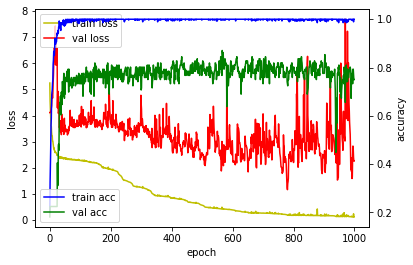

In [23]:
# Visualize Training Process and Result
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()